A hydrostatic model in isentropic coordinates implementing the symmetrized sequential-update method
==

In [1]:
from datetime import timedelta
import gridtools as gt
import numpy as np
import os
import tasmania as taz

# Interactive plotting
from IPython import display
%matplotlib nbagg

import namelist_isentropic_dry as nl

The underlying grid
--

In [2]:
grid = taz.GridXYZ(
    nl.domain_x, nl.nx, nl.domain_y, nl.ny, nl.domain_z, nl.nz,
    topo_type=nl.topo_type, topo_time=nl.topo_time, topo_kwargs=nl.topo_kwargs,
    dtype=nl.dtype
)

The initial state
--

In [3]:
if nl.isothermal:  # uniform temperature
    state = taz.get_isothermal_isentropic_state(
        grid, nl.init_time, nl.init_x_velocity, nl.init_y_velocity,
        nl.init_temperature, dtype=nl.dtype
    )
else:  # uniform brunt-vaisala frequency
    state = taz.get_default_isentropic_state(
        grid, nl.init_time, nl.init_x_velocity, nl.init_y_velocity,
        nl.init_brunt_vaisala, dtype=nl.dtype
    )
    

The dynamical core
--

In [4]:
dycore = taz.HomogeneousIsentropicDynamicalCore(
    grid, time_units='s', moist=False, substeps=0,
    # numerical scheme
    time_integration_scheme=nl.time_integration_scheme,
    horizontal_flux_scheme=nl.horizontal_flux_scheme,
    horizontal_boundary_type=nl.horizontal_boundary_type,
    # vertical damping
    damp=nl.damp, damp_type=nl.damp_type, damp_depth=nl.damp_depth,
    damp_max=nl.damp_max, damp_at_every_stage=nl.damp_at_every_stage,
    # horizontal smoothing
    smooth=nl.smooth, smooth_type=nl.smooth_type,
    smooth_damp_depth=nl.smooth_damp_depth,
    smooth_coeff=nl.smooth_coeff, smooth_coeff_max=nl.smooth_coeff_max,
    smooth_at_every_stage=nl.smooth_at_every_stage,
    # backend settings
    backend=nl.backend, dtype=nl.dtype
)

The physics
--

In [5]:
# Component calculating the pressure gradient in isentropic coordinates
order = 4 if nl.horizontal_flux_scheme == 'fifth_order_upwind' else 2
pg = taz.ConservativeIsentropicPressureGradient(
    grid, order=order,
    horizontal_boundary_type=nl.horizontal_boundary_type,
    backend=nl.backend, dtype=nl.dtype
)

# Component retrieving the diagnostic variables
pt = state['air_pressure_on_interface_levels'][0, 0, 0]
dv = taz.IsentropicDiagnostics(
    grid, moist=True, pt=pt, backend=nl.backend, dtype=nl.dtype
)

# The component calculating the velocity components
vc = taz.IsentropicVelocityComponents(
    grid, horizontal_boundary_type=nl.horizontal_boundary_type, 
    reference_state=state, backend=nl.backend, dtype=nl.dtype
)

if nl.coriolis:
    # Component calculating the Coriolis acceleration
    cf = taz.ConservativeIsentropicCoriolis(
        grid, coriolis_parameter=nl.coriolis_parameter, dtype=nl.dtype
    )

    # Wrap the components in two SequentialUpdateSplitting objects
    physics_before_dynamics = taz.SequentialUpdateSplitting(
        {'component': cf, 'time_integrator': 'rk2', 'substeps': 1},
        {'component': pg, 'time_integrator': 'rk2', 'substeps': 1}, 
        {'component': vc}
    )
    physics_after_dynamics = taz.SequentialUpdateSplitting(
        {'component': dv}, 
        {'component': pg, 'time_integrator': 'rk2', 'substeps': 1}, 
        {'component': cf, 'time_integrator': 'rk2', 'substeps': 1},
        {'component': vc}
    )
else:
    # Wrap the components in two SequentialUpdateSplitting objects
    physics_before_dynamics = taz.SequentialUpdateSplitting(
        {'component': pg, 'time_integrator': 'rk2', 'substeps': 1}, 
        {'component': vc}
    )
    physics_after_dynamics = taz.SequentialUpdateSplitting(
        {'component': dv}, 
        {'component': pg, 'time_integrator': 'rk2', 'substeps': 1}, 
        {'component': vc}
    )

A NetCDF monitor
--

In [6]:
if nl.filename is not None:
    if os.path.exists(nl.filename):
        os.remove(nl.filename)
    netcdf_monitor = taz.NetCDFMonitor(nl.filename, grid)
    netcdf_monitor.store(state)

A visualization monitor
--

In [7]:
# The drawers and the artist generating the left subplot
drawer1_properties = {
    'fontsize': 16, 'cmap_name': 'BuRd', 'cbar_on': True, 
    'cbar_levels': 18, 'cbar_ticks_step': 4, 'cbar_center': 15,
    'cbar_orientation': 'horizontal',
    'cbar_x_label': 'Horizontal velocity [m s$^{-1}$]',
    'draw_vertical_levels': False,
}
drawer1 = taz.Contourf(
    grid, 'horizontal_velocity', 'm s^-1', z=-1,  
    xaxis_units='km', yaxis_units='km', properties=drawer1_properties,
)
drawer2_properties = {
    'fontsize': 16, 'x_step': 2, 'y_step': 2, 'colors': 'black',
    'draw_vertical_levels': False, 'alpha': 0.5,
}
drawer2 = taz.Quiver(
    grid, z=-1, xaxis_units='km', yaxis_units='km',
    xcomp_name='x_velocity', xcomp_units='m s^-1',
    ycomp_name='y_velocity', ycomp_units='m s^-1',
    properties=drawer2_properties
)
axes1_properties = {
    'fontsize': 16, 'title_left': '$\\theta = 300$ K',
    'x_label': '$x$ [km]', 'x_lim': [-250, 250],
    'y_label': '$y$ [km]', 'y_lim': [-250, 250],
}
topo_drawer = taz.Contour(
    grid, 'topography', 'm', z=-1,
    xaxis_units='km', yaxis_units='km', properties={'colors': 'darkgray'}
)
plot1 = taz.Plot((drawer1, drawer2, topo_drawer), axes_properties=axes1_properties)

# The drawer and the artist generating the right subplot
drawer3_properties = {
    'fontsize': 16, 'cmap_name': 'BuRd', 'cbar_on': True, 
    'cbar_levels': 18, 'cbar_ticks_step': 4, 'cbar_center': 15,
    'cbar_orientation': 'horizontal',
    'cbar_x_label': '$x$-velocity [m s$^{-1}$]',
    'draw_vertical_levels': True,
}
drawer3 = taz.Contourf(
    grid, 'x_velocity_at_u_locations', 'm s^-1', y=int(nl.ny/2), 
    xaxis_units='km', zaxis_name='height', zaxis_units='km',
    properties=drawer3_properties,
)
axes3_properties = {
    'fontsize': 16, 'title_left': '$y = 0$ km',
    'x_label': '$x$ [km]', 'x_lim': [-250, 250],
    'y_label': '$z$ [km]', 'y_lim': [0, 14],
}
topo_drawer = taz.LineProfile(
    grid, 'topography', 'km', y=int(nl.ny/2), z=-1, axis_units='km', 
    properties={'linecolor': 'black', 'linewidth': 1.3}
)
plot2 = taz.Plot((drawer3, topo_drawer), axes_properties=axes3_properties)

# The monitor encompassing and coordinating the two artists
figure_properties = {'fontsize': 16, 'figsize': (12, 7), 'tight_layout': True}
plot_monitor = taz.PlotComposite(
    nrows=1, ncols=2, artists=(plot1, plot2), interactive=False, figure_properties=figure_properties
)

Simulation
--

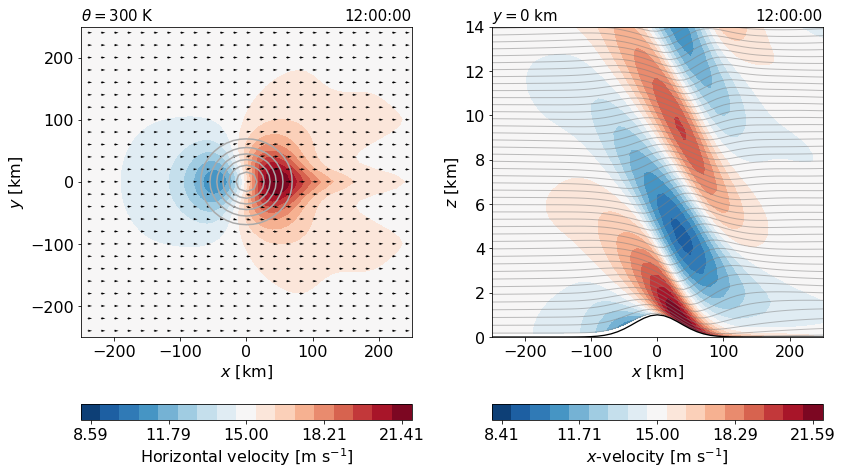

Simulation successfully completed. HOORAY!


In [8]:
# Simulation settings
dt = nl.timestep
nt = nl.niter

# Fake call to the dycore to let it grab the correct reference state
_ = dycore(state, {}, dt)
 
# Integrate
for i in range(nt):
    # Update the (time-dependent) topography
    dycore.update_topography((i+1) * dt)
  
    # Compute the physics before the dynamics
    physics_before_dynamics(state, 0.5*dt)
    
    # Ensure the state is still defined at the current time level
    state['time'] = nl.init_time + i*dt
    
    # Compute the dynamics
    state_new = dycore(state, {}, dt)
    
    # Ensure the state is still defined at the half time level
    state_new['time'] = nl.init_time + (i + 0.5)*dt
     
    # Compute the physics after the dynamics
    physics_after_dynamics(state_new, 0.5*dt)
    
    # Ensure the state is defined at the next time level
    state_new['time'] == nl.init_time + (i + 1)*dt
    
    # Update the state
    taz.dict_update(state, state_new)
    
    if (nl.print_frequency > 0) and ((i + 1) % nl.print_frequency == 0):
        u = state['x_velocity_at_u_locations'].to_units('m s^-1').values[...]
        v = state['y_velocity_at_v_locations'].to_units('m s^-1').values[...]
  
        umax, umin = u.max(), u.min()
        vmax, vmin = v.max(), v.min()
        cfl = max(umax * dt.total_seconds() / grid.dx.to_units('m').values.item(),
                  vmax * dt.total_seconds() / grid.dy.to_units('m').values.item())
 
        # Print useful info
        print('Iteration {:6d}: CFL = {:4f}, umax = {:8.4f} m/s, umin = {:8.4f} m/s, '
              'vmax = {:8.4f} m/s, vmin = {:8.4f} m/s'.format(i+1, cfl, umax, umin, vmax, vmin))
    # Shortcuts
    to_save = (nl.filename is not None) and \
        (((nl.save_frequency > 0) and
          ((i + 1) % nl.save_frequency == 0)) or i + 1 == nt)
    to_plot = (nl.plot_frequency > 0) and ((i+1) % nl.plot_frequency == 0)
    
    if to_save:
        # Save the solution
        netcdf_monitor.store(state)

    if to_plot:
        # Plot the solution
        plot1.axes_properties['title_right'] = str((i+1)*dt)
        plot2.axes_properties['title_right'] = str((i+1)*dt)
        fig = plot_monitor.store(((state, state, state), (state, state)), show=False)
        display.clear_output(wait=True)
        display.display(fig)
        
print('Simulation successfully completed. HOORAY!')

Post-processing
--

In [9]:
if nl.filename is not None:
    netcdf_monitor.write()